# Importing ONNX models to CoreML

We'll show how you can use ONNX-CoreML to convert ONNX models into CoreML, and use the imported model for inference (or import it to your XCode project later).
	
## Step 1: Installations
	
First, install ONNX, following instructions on the ONNX repo. Also, make sure that [coremltools](https://github.com/apple/coremltools) are installed.

NOTE: In order to run CoreML models on your Mac you'd need Mac OS 10.13.

Then, install [onnx-coreml](https://github.com/onnx/onnx-coreml) package:

```
$ pip install onnx-coreml
```
	
## Step 2: Prepare an ONNX model to import

In this example, we will demonstrate importing a Super Resolution model, designed to increase spatial resolution of images. The model was built and trained with PyTorch, and exported into ONNX using PyTorch's ONNX export API. More details about the model design are available in [PyTorch's tutorial here](https://github.com/onnx/tutorials/blob/master/tutorials/PytorchCaffe2SuperResolution.ipynb).

Model is already available as a part of this repo in [assets folder](https://github.com/onnx/tutorials/tree/master/tutorials/assets). We'd need to files: `cat.jpg` as a sample input image and `super_resolution.onnx` with the exported model.

In [1]:
import onnx
import onnx_coreml
model = onnx.load('assets/super_resolution.onnx')

# Step 3: Converting the model to CoreML

It's as easy as running `convert` function. Resulting object is coremltools's `MLModel` object that you can save to a file and import in XCode later

In [2]:
cml = onnx_coreml.convert(model)
print(type(cml))
cml.save('output/super_resolution.mlmodel')

<class 'coremltools.models.model.MLModel'>


# Step 4: Testing inference with coremltools

Usually you'd import the resulting model to XCode. Here we're going to demonstrate that inference works using coremltools. Remember, that you need MacOS 10.13 for that.

First, let's preprocess input image

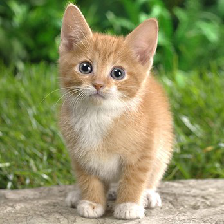

(1, 224, 224)


In [9]:
import numpy as np
from PIL import Image
from IPython.core.display import display

# load the image
img = Image.open("assets/cat.jpg").resize([224, 224])
display(img)

# load the resized image and convert it to Ybr format
img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

# layout should be CxHxW - CoreML supports either rank-3 or rank-5 tensors
data = np.array(img_y)[np.newaxis, :, :].astype(np.float32)
print(data.shape)

# name of input and output of our model
input_name = cml.get_spec().description.input[0].name
output_name = cml.get_spec().description.output[0].name

Now, invoke the model and grab the output

In [10]:
img_out = cml.predict({input_name: data})[output_name]

Stitch together the original color channels and show result

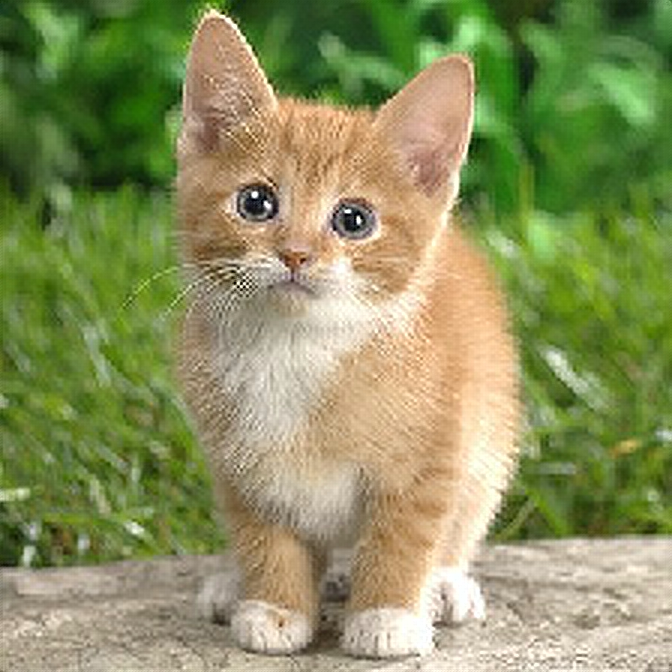

In [11]:
img_out_y = Image.fromarray(np.uint8((img_out[0,0]).clip(0, 255)), mode='L')

# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")

# Show the picture
display(final_img)